In [1]:
%load_ext lab_black

# Population weighted HDD

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regionmask
from scipy.stats import genextreme as gev
import xarray as xr

from codebase.fig import figname

In [3]:
hdd = xr.open_mfdataset("../data/processed/era5/hdd_*.nc")["HDD"].compute()

Create the lags as befores

In [4]:
DURATIONS = np.arange(1, 8)
hdd_roll = xr.concat(
    [hdd.rolling(time=dur).mean().assign_coords({"lag": dur}) for dur in DURATIONS],
    dim="lag",
)

In [5]:
pop = xr.open_dataarray("../data/raw/gpwv4/gpw_v4_population_count_rev11_30_min.nc")

This has a bunch of layers called `raster`.
What do they mean?
Raster 1 is 2000 population, 2 is 2005, ... 5 is 2020.
The rest are data quality indicators.
We only want 1-5.
Let's fix the way that data looks

In [6]:
pop = (
    pop.sel(raster=slice(1, 5))
    .assign_coords(pop_year=("raster", [2000, 2005, 2010, 2015, 2020]))
    .drop_vars("raster")
    .rename({"raster": "pop_year"})
)

Now subset it and interpolate onto having the same grid as the heating degree days

In [7]:
pop_interp = pop.interp_like(hdd_roll)
np.testing.assert_array_almost_equal(pop_interp.longitude, hdd.longitude)
np.testing.assert_array_almost_equal(pop_interp.latitude, hdd.latitude)

Great!
Now we can do "data fusion"

![data fusion](https://www.delawareconsulting.com/-/media/New-Corporate-Folder/DBE/Landingpages/Artificial-Intelligence/Website_Landingpage_ArtificialIntelligence_780x340.ashx?v=c238a9644f6843918fa91c35a97de4e1&la=en-US&h=341&w=770&mw=770&hash=80D54AE50822710F9D5077D8798A9C163F14D9A2)

Here's the population weighted heating degree days

In [8]:
pop_hdd = pop_interp * hdd_roll

Now let's get our annual maximum extremes

In [9]:
times = pd.to_datetime(pop_hdd["time"].values)
year_eff = times.year + np.int_(times.month > 7)
pop_hdd["year_eff"] = xr.DataArray(
    year_eff, coords={"time": pop_hdd["time"]}, dims="time"
)
annual = pop_hdd.groupby("year_eff").max(dim="time")
annual = annual.rename({"longitude": "lon", "latitude": "lat"})  # naming conventions

Subset to just Texas and average over space, weighting by population

In [10]:
states = regionmask.defined_regions.natural_earth.us_states_50
mask = states.mask(annual)
tx_idx = states.map_keys("Texas")
pop_hdd_tx = annual.where(mask == tx_idx).mean(dim=["lon", "lat"])

Now we can construct our IDF curves

In [11]:
return_period = np.linspace(5, 250, 1000)
colors = [plt.cm.viridis(x) for x in DURATIONS / np.max(DURATIONS)]
ticks = [5, 10, 25, 50, 100, 250]

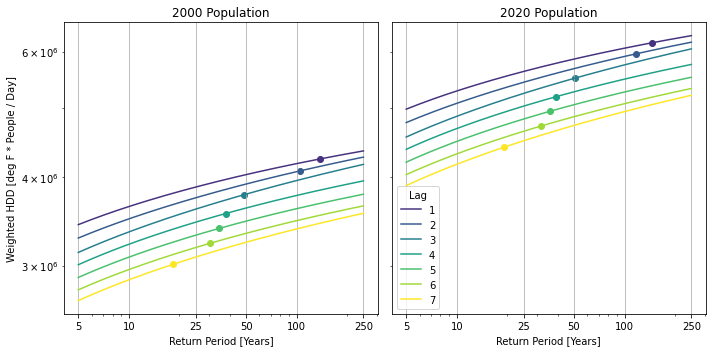

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True, sharey=True)

for ax, pop_year in zip(axes, [2000, 2020]):
    for c, lag in zip(colors, DURATIONS):
        sub = pop_hdd_tx.sel(pop_year=pop_year, lag=lag)
        x = sub.sel(year_eff=slice(1950, 2020)).values
        y = sub.sel(year_eff=2021).values

        theta = gev.fit(x, 0, loc=1e6, scale=1e5)
        return_level = gev(*theta).isf(1 / return_period)
        ax.plot(return_period, return_level, label=lag, c=c)

        return_y = 1 / (1 - gev(*theta).cdf(y))
        ax.scatter(return_y, y, color=c)

        ax.loglog()
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks)
        ax.set_xlabel("Return Period [Years]")
        ax.grid(True)
        ax.set_title(f"{pop_year} Population")

axes[0].set_ylabel("Weighted HDD [deg F * People / Day]")
ax.legend(title="Lag")  # only needed once
fig.tight_layout()
plt.savefig(figname("pop_weighted_idf.pdf"))
plt.show()